In [1]:
import os
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import s3_input
from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.serving import Predictor
from tensorflow.python.keras.utils import to_categorical
import yaml

from entry_points.kmnist_cnn import (DATA_DIR, KMNIST_DATA_DIR, NUM_CLASSES, PWD, 
                                     TEST_DATA_OFFSET, preprocess_images)

plt.rcParams['font.family'] = 'IPAPGothic'  # TO-DO: Check detail and decide to remove or not
%matplotlib inline

In [2]:
SETTINGS_YML = PWD.joinpath('..', '..', 'settings.yml')

In [3]:
with SETTINGS_YML.open() as f:
    SETTINGS = yaml.load(f)

## Data Stored in Local Directory

In [4]:
X_TRAIN_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-train-imgs.npz')
Y_TRAIN_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-train-labels.npz')
X_TEST_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-test-imgs.npz')
Y_TEST_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-test-labels.npz')

In [5]:
CLASSMAP = KMNIST_DATA_DIR.joinpath('kmnist_classmap.csv')

In [6]:
if not KMNIST_DATA_DIR.exists():
    KMNIST_DATA_DIR.mkdir(parents=True, exist_ok=True)
    for filepath in [X_TRAIN_NPZ, Y_TRAIN_NPZ, X_TEST_NPZ, Y_TEST_NPZ, CLASSMAP]:
        filename = filepath.name
        url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/' + filename
        !curl --output $filepath $url

## AWS Account, Role and Misc Config

As of `2019-10-08`, `sagemaker.get_execution_role()` fails to be executed properly and raises `ValueError`. So the SageMaker role must be set manually to use the computing resources on the cloud.

In [7]:
# AWS account and SageMaker role info
try:
    ROLE = get_execution_role()
except ValueError:
    AWS_ACCOUNT_ID = SETTINGS['aws']['sagemaker']['account_id']
    ROLE_NAME = SETTINGS['aws']['sagemaker']['role_name']
    ROLE = f'arn:aws:iam::{AWS_ACCOUNT_ID}:role/service-role/{ROLE_NAME}'

# Data location at S3
BUCKET_NAME = SETTINGS['aws']['s3']['bucket']['name']
PREFIX = 'sagemaker/kuzushiji'

Couldn't call 'get_role' to get Role ARN from role name m-sato to get Role path.


## Create Session to Access S3

In [8]:
SESS = sagemaker.Session()

In [9]:
BUCKET_NAME = SESS.default_bucket()

In [10]:
S3 = boto3.resource('s3')
BUCKET = S3.Bucket(BUCKET_NAME)

print(BUCKET.name)

sagemaker-us-east-1-540801573371


## Load Classes as DataFrame

In [11]:
df_classes = pd.read_csv(CLASSMAP)
df_classes.head()

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な


In [12]:
classes = df_classes.set_index('index').to_dict()['char']
classes

{0: 'お',
 1: 'き',
 2: 'す',
 3: 'つ',
 4: 'な',
 5: 'は',
 6: 'ま',
 7: 'や',
 8: 'れ',
 9: 'を'}

## Load and Visualize Test Data

In [13]:
# Load test data
X_test = np.load(X_TEST_NPZ)['arr_0']
y_test = np.load(Y_TEST_NPZ)['arr_0']

In [14]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


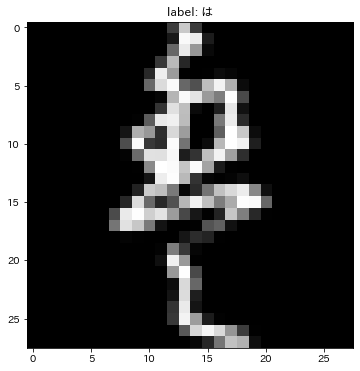

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X_test[423], cmap='gray')
ax.grid(False)
ax.set_title(f"label: {classes[y_test[423]]}")
fig.show()

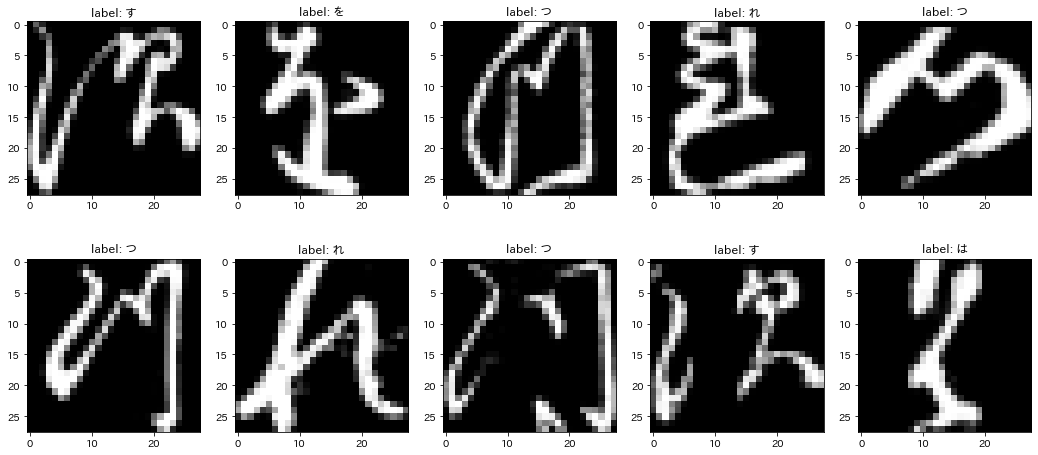

In [16]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test[i], cmap='gray')
    ax[i // ncols, i % ncols].set_title(f"label: {classes[y_test[i]]}")
fig.show()

## Train the Model on SageMaker Instances

Train on one or more the SageMaker instances the simple convolutional neural network model implemented by the TensorFlow-backended Keras. For training, the `estimator` must be created with the following minimal configuration:

1. `entry_point`: Python script to be used as entry point of the `estimator`
2. `role`: SageMaker role assigned to your account
3. `train_instance_count`: number to instances to use for training
4. `train_instance_type`: type of instances to use for training
5. `framework_version`: TensorFlow version in your runtime environment
6. `py_version`: Python version used in your runtime environment
7. `script_mode`: Whether or not the script mode is used for the `estimator`

More information is available at [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html).

In [24]:
ENTRY_POINT = str(PWD.joinpath('entry_points', 'kmnist_cnn.py'))

In [26]:
estimator = TensorFlow(entry_point=ENTRY_POINT, role=ROLE, 
                       train_instance_count=2, train_instance_type='ml.p3.2xlarge',
                       framework_version='1.13.1', py_version='py3', 
                       script_mode=True)

All the training data stored in S3 will be used to train the model, some portion of test data for validation.

In [27]:
s3_train_path = f's3://{BUCKET.name}/{PREFIX}/train'
s3_test_path = f's3://{BUCKET.name}/{PREFIX}/test'

In [28]:
estimator.fit(
    inputs={'train': s3_input(s3_train_path), 'test': s3_input(s3_test_path)}, 
    logs=False
)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: No S3 objects found under S3 URL "s3://sagemaker-us-east-1-540801573371/sagemaker/kuzushiji/train" given in input data source. Please ensure that the bucket exists in the selected region (us-east-1), that objects exist under that S3 prefix, and that the role "arn:aws:iam::540801573371:role/service-role/AmazonSageMaker-ExecutionRole-20190722T170243" has "s3:ListBucket" permissions on bucket "sagemaker-us-east-1-540801573371".

## Check Perfomance of the Trained Model with Several Test Images

After finished training, send the test data in your local machine to the HTTPS endpoint hosting where the trained model is deployed.

**NOTE**: As of 2019-10-08, `endpoint_name` should not be specified or otherwise the model fails to be deployed.

In [ ]:
ENDPOINT_NAME = 'kmnist'

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
                             endpoint_name=ENDPOINT_NAME)

Originally the pixel values of each image data range from `0` to `255`, so normalize them in between `0.0` and `1.0` and reshape the tensor (the collection of all the image data) so that they are compatible with the machine learning models to be used.

In [ ]:
# Normalize and reshape test data
X_test = preprocess_images(X_test[TEST_DATA_OFFSET:], reshape=True)

# One-hot encode test data
y_test = to_categorical(y_test[TEST_DATA_OFFSET:], NUM_CLASSES)

In [ ]:
def get_y_pred(predictor: Predictor, X_test: np.ndarray) -> int:
    """Predict label for test dataset."""
    X_test_reshaped = X_test.reshape((1,) + X_test.shape)
    return np.argmax(predictor.predict(X_test_reshaped)['predictions'][0])

In [ ]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    y_pred = get_y_pred(predictor, X_test[i])
    ax[i // ncols, i % ncols].imshow(
        X_test[i].reshape(X_test[i].shape[:2]), cmap='gray')
    title = f"pred {classes[int(y_pred)]}, ans: {classes[y_test[i].argmax()]}"
    ax[i // ncols, i % ncols].set_title(title)
fig.show()

Delete the model deployed to endpoint if necessary.

In [ ]:
DELETE_ENDPOINT = settings['endpoint']['delete']

In [ ]:
if DELETE_ENDPOINT:
    SESS.delete_endpoint(predictor.endpoint)